### Figure 1A - heatmap/sequence of RBD + NAb contact

In [1]:
import pandas as pd
from Bio.SeqIO import parse
import numpy as np
import re

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Load data

In [3]:
ace2_contact_df = pd.read_csv('../data/refs/SARS2_ACE2_contact_residues.Lan_and_Shang_2020_Nature.txt', 
                              sep='\t', index_col=0)
ace2_contact_df = ace2_contact_df[ace2_contact_df['paper']=='Lan2020Nature']
print(ace2_contact_df.shape)
ace2_contact_df.head(2)

(17, 2)


paper notes
contact_residues                     
K417              Lan2020Nature   NaN
G446              Lan2020Nature   NaN

In [4]:
ab_contact_df = pd.read_csv('../data/refs/SARS2_NAb_contact_residues.txt', sep='\t')

# add pos col for sorting
ab_contact_df['aa'] = ab_contact_df['contact_residues'].apply(lambda x: x[0])
ab_contact_df['pos'] = ab_contact_df['contact_residues'].apply(lambda x: int(x[1:])-1)

print(ab_contact_df.shape)
ab_contact_df.head(2)

(141, 7)


contact_residues Ab_name paper                                        DOI  \
0             K378   2196*  Zost  https://doi.org/10.1038/s41586-020-2548-6   
1             K386   2196*  Zost  https://doi.org/10.1038/s41586-020-2548-6   

               notes aa  pos  
0  critical_residues  K  377  
1  critical_residues  K  385

In [5]:
# spike protein reference
with open('../data/refs/P0DTC2.fasta', 'r') as handle:
    for line in parse(handle, 'fasta'):
        sp = str(line.seq)

# get ref residues
ref_residues = ['{}{}'.format(aa,i+1) for i, aa in enumerate(sp)]
ref_residues[:5]

['M1', 'F2', 'V3', 'F4', 'L5']

In [6]:
region_domains = {
    'RBD (319-541)': (319-1,541, 'orange'),
    'RBD motif (437-508)': (437-1, 508, 'red'),
    'Fusion peptide 1 (816-837)': (816-1, 837, 'lightgreen'),
    'Fusion peptide 2 (835-855)': (835-1, 855, 'darkgreen'),
    'Heptad repeat 1 (920-970)': (920-1, 970, 'darkblue'),
    'Heptad repeat 2 (1163-1202)': (1163-1, 1202, 'blue')
}

### Plot
- Only RBM positions

In [7]:
rbm_contact_df = ab_contact_df[ab_contact_df['pos'].isin(range(*region_domains['RBD motif (437-508)'][:2]))]
rbm_contact_df = rbm_contact_df.sort_values(by='pos', ascending=True)
rbm_contact_df = rbm_contact_df.pivot_table(index='contact_residues', columns='Ab_name', values='pos', aggfunc='count')

rbm_contact_df.head(2)

Ab_name           2196*  B38  CB6  CC12.3  S2H14
contact_residues                                
A475                NaN  1.0  1.0     1.0    1.0
F456                NaN  1.0  1.0     1.0    1.0

In [8]:
ref_residues = pd.DataFrame([x for x in ref_residues if int(x[1:]) in range(*region_domains['RBD motif (437-508)'][:2])]).set_index(0)
ref_residues.head(2)

Empty DataFrame
Columns: []
Index: [W436, N437]

In [9]:
# add reference residues for completeness
heatmap_df = ref_residues.join(rbm_contact_df, how='left').fillna(0)

# just show amino acid for heatmap
heatmap_df.index = [x[0] for x in heatmap_df.index] 
heatmap_df.head(2)

2196*  B38  CB6  CC12.3  S2H14
W    0.0  0.0  0.0     0.0    0.0
N    0.0  0.0  0.0     0.0    0.0

In [10]:
# make ACE2 binding annotation df
ace2_contact_df = ref_residues.join(ace2_contact_df, how='left')
ace2_contact_df['ACE2 contact'] = ace2_contact_df['paper'].apply(lambda x: '•' if x is not np.nan else '')

ace2_annot_df = heatmap_df.copy()
for ab in ab_contact_df['Ab_name'].unique():
    ace2_annot_df[ab] = ace2_contact_df[['ACE2 contact']].values
ace2_annot_df.head()

2196* B38 CB6 CC12.3 S2H14
W                           
N                           
S                           
N                           
N

### Make Fig 1

Saving to ../data/figures/Fig1D.pdf


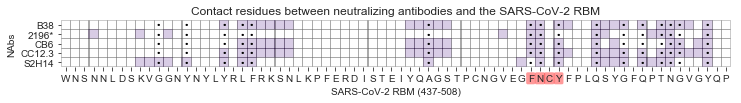

In [11]:
ab_order = ['B38', '2196*','CB6', 'CC12.3', 'S2H14']

plt.figure(figsize=(12,6))
ax = sns.heatmap(heatmap_df[ab_order].T, annot=ace2_annot_df[ab_order].T, fmt = '', annot_kws={'color': 'k'},
            square=True, xticklabels=True, yticklabels=True, cmap='Purples', cbar=False, 
                 lw=0.15, alpha=0.2, linecolor='k')
plt.title('Contact residues between neutralizing antibodies and the SARS-CoV-2 RBM')
plt.xlabel('SARS-CoV-2 RBM (437-508)'), plt.ylabel('NAbs')

for i, tick in enumerate(ax.get_xticklabels()):
    pos = i+437
    if pos in range(487,490+1):
        color = 'red'
        bbox = dict(boxstyle="round", color=color, alpha=0.4, pad=0.15, lw=0) 
        plt.setp(tick, bbox=bbox)

savepath = '../data/figures/Fig1D.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath)

plt.show()